# **1. Import library**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,  
    classification_report,
    mean_absolute_error, 
    mean_squared_error, 
    explained_variance_score,
    f1_score,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# **2. Load normalized data**

In [2]:
normalized_data = pd.read_csv('../processed_data/normalized_data.csv')
X = normalized_data.drop("attack_cat", axis=1).values
y = normalized_data["attack_cat"].values

In [3]:
X

array([[2.02463370e-03, 4.69704086e-04, 3.63042294e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08317020e-02, 1.22123062e-03, 3.44890180e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.70521550e-02, 6.57585721e-04, 1.45216918e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000028e-07, 9.39408173e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [4]:
y

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

# **3. Splitting and Encode data**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
label_encoder = LabelEncoder()

In [7]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# **3. Training Linear Support Vector Machine model**

In [8]:
mlp = MLPClassifier(random_state=123, solver='adam', max_iter=8000)

# Start time
start_time = time.time()

mlp.fit(X_train, y_train_encoded)

# End time
end_time = time.time()

In [9]:
y_pred_encoded = mlp.predict(X_test)

In [10]:
# Save model
pkl_filename = "../models/mlp.h5"
with open(pkl_filename, 'wb') as file:
    pickle.dump(mlp, file)

# **4. Confusion maxtrix**

In [11]:
target_names=[
    'Analysis', 
    'Backdoor', 
    'DoS', 
    'Exploits', 
    'Fuzzers', 
    'Generic', 
    'Normal', 
    'Reconnaissance', 
    'Shellcode', 
    'Worms'
]

In [12]:
# Create confusion matrix
confusion_matrix_result = confusion_matrix(y_test_encoded, y_pred_encoded, labels=np.arange(len(target_names)))
confusion_matrix_result

array([[   25,     1,    85,   277,    30,     0,   101,     0,     0,
            0],
       [    0,     6,    75,   331,    39,     0,    11,     4,     2,
            0],
       [    0,     7,   687,  2405,    62,    15,    83,    18,    15,
            0],
       [    5,     6,   830,  7487,   243,    23,   312,   137,    37,
            0],
       [    0,     2,    78,   504,  2078,     3,  2108,    47,    11,
            0],
       [    0,     0,    33,   177,    18, 11280,    23,     3,     1,
            2],
       [    7,     0,     1,    94,   498,     7, 17914,    76,    16,
            0],
       [    0,     0,   111,   565,    20,     2,    52,  2098,     4,
            0],
       [    0,     0,     3,    46,    13,     2,    60,    40,   145,
            0],
       [    0,     0,     0,    27,     0,     0,     0,     0,     0,
            7]], dtype=int64)

In [13]:
# Compute confusion matrix
def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True
):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

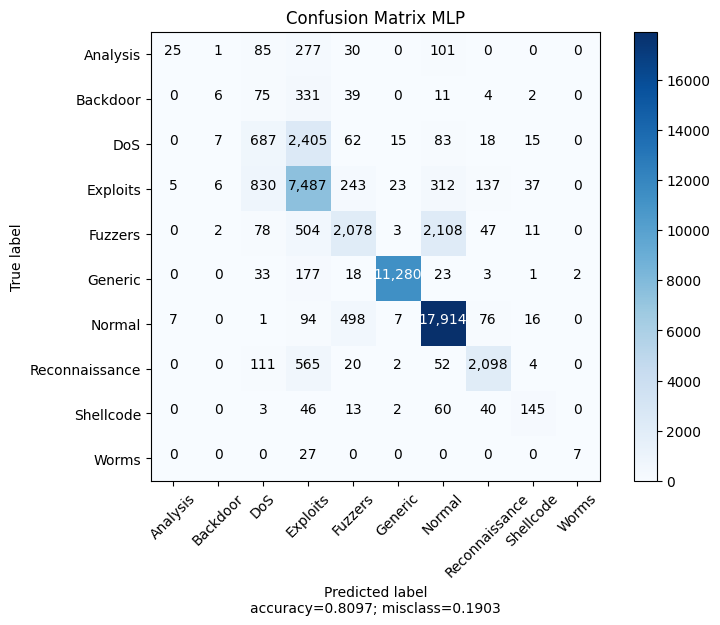

In [14]:
# Plot confusion matrix
plot_confusion_matrix(
    confusion_matrix_result, 
    normalize=False,
    target_names=target_names, 
    title="Confusion Matrix MLP"
)

# **5. Calculate metrics**

In [15]:
# Training time
training_time = end_time - start_time
print(f"Training time: {training_time/60:.2f} minutes")

Training time: 11.49 minutes


In [16]:
# Tính Detection Rate và False Positive Rate
tp = np.diag(confusion_matrix_result)  # True Positives
fn = np.sum(confusion_matrix_result, axis=1) - tp  # False Negatives
fp = np.sum(confusion_matrix_result, axis=0) - tp  # False Positives

In [17]:
detection_rate = tp / (tp + fn)
fpr = fp / (fp + np.sum(confusion_matrix_result, axis=1) - tp)
df = pd.DataFrame({"Class": target_names, "False Positive Rate": fpr, "Detection Rate": detection_rate})

# Hiển thị bảng
print(df)

            Class  False Positive Rate  Detection Rate
0        Analysis             0.023715        0.048170
1        Backdoor             0.033473        0.012821
2             DoS             0.318241        0.208688
3        Exploits             0.735338        0.824559
4         Fuzzers             0.251088        0.430139
5         Generic             0.168285        0.977724
6          Normal             0.797333        0.962446
7  Reconnaissance             0.301205        0.735624
8       Shellcode             0.344000        0.469256
9           Worms             0.068966        0.205882


In [18]:
print("Mean Absolute Error - " , mean_absolute_error(y_test_encoded, y_pred_encoded))
print("Mean Squared Error - " , mean_squared_error(y_test_encoded, y_pred_encoded))
print("Root Mean Squared Error - " , np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded)))
print("R2 Score - " , explained_variance_score(y_test_encoded, y_pred_encoded)*100)
print("F1 Score - ", f1_score(y_test_encoded, y_pred_encoded, average='weighted') * 100)
print("Accuracy - ",accuracy_score(y_test_encoded, y_pred_encoded)*100)

Mean Absolute Error -  0.3719025904724944
Mean Squared Error -  0.9799941787134957
Root Mean Squared Error -  0.9899465534631128
R2 Score -  59.00221490761206
F1 Score -  79.11961501887616
Accuracy -  80.96827398855146


In [19]:
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))

                precision    recall  f1-score   support

      Analysis       0.68      0.05      0.09       519
      Backdoor       0.27      0.01      0.02       468
           DoS       0.36      0.21      0.26      3292
      Exploits       0.63      0.82      0.71      9080
       Fuzzers       0.69      0.43      0.53      4831
       Generic       1.00      0.98      0.99     11537
        Normal       0.87      0.96      0.91     18613
Reconnaissance       0.87      0.74      0.80      2852
     Shellcode       0.63      0.47      0.54       309
         Worms       0.78      0.21      0.33        34

      accuracy                           0.81     51535
     macro avg       0.68      0.49      0.52     51535
  weighted avg       0.80      0.81      0.79     51535

